# NON-ISCHEMIC HEART DISEASE CLASSIFICATION IN YOUNGER ADULTS
#  Machine Learning Model Using PTB-XL Metadata

1. IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

2. LOAD DATASETS
Replace with correct path to your CSV files:

In [4]:
db = pd.read_csv("ptbxl_database.csv")
scp = pd.read_csv("scp_statements.csv")


3. MAP DIAGNOSTIC SUBCLASSES TO DIAGNOSTIC CLASSES

In [5]:
mapping = dict(zip(scp["diagnostic_subclass"], scp["diagnostic_class"]))


4. EXTRACT DIAGNOSTIC CLASSES FROM SCP CODES

In [6]:
def extract_diag_classes(x):
    classes = set()
    try:
        code_dict = ast.literal_eval(x)
        for sub in code_dict.keys():
            if sub in mapping:
                classes.add(mapping[sub])
    except:
        pass
    return list(classes)

db["diag_classes"] = db["scp_codes"].apply(extract_diag_classes)


5. FILTER YOUNGER ADULTS (<45 YEARS)

In [8]:
df = db[db["age"] < 45].copy()

6. REMOVE ISCHEMIC CASES (MI)

In [ ]:
df = df[df["diag_classes"].apply(lambda x: "MI" not in x)]

7. CREATE TARGET LABELS (STRUCTURAL VS NON-STRUCTURAL)

In [10]:
def new_target(row):
    classes = row["diag_classes"]

    if any(c in ["CM", "HYP"] for c in classes):
        return 1   # structural

    if any(c in ["CD", "NDT"] for c in classes):
        return 0   # non-structural

    return None

df["target"] = df.apply(new_target, axis=1)
df = df.dropna(subset=["target"])
df["target"] = df["target"].astype(int)

print("Final dataset size:", df.shape)
print(df["target"].value_counts())

Final dataset size: (492, 30)
target
0    300
1    192
Name: count, dtype: int64


 8. SELECT FEATURES (METADATA ONLY)

features = ["age", "sex", "height", "weight", "nurse", "site", "device"]

df_ml = df[features + ["target"]].dropna()

# One-hot encode categoricals
df_ml = pd.get_dummies(df_ml, columns=["device"], drop_first=True)

X = df_ml.drop("target", axis=1)
y = df_ml["target"]


 9. TRAIN-TEST SPLIT

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

10. TRAIN RANDOM FOREST MODEL

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
11. MODEL EVALUATION

Accuracy: 0.6842105263157895

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.57      0.57      0.57         7

    accuracy                           0.68        19
   macro avg       0.66      0.66      0.66        19
weighted avg       0.68      0.68      0.68        19



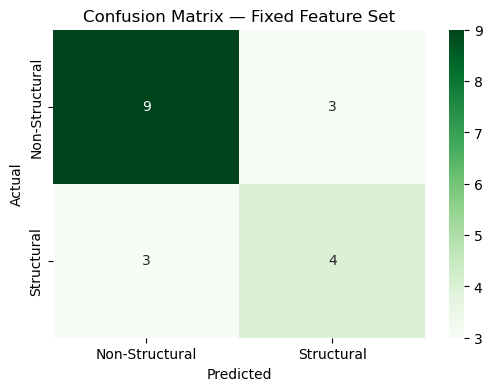

In [21]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d",
            xticklabels=["Non-Structural", "Structural"],
            yticklabels=["Non-Structural", "Structural"])
plt.title("Confusion Matrix — Fixed Feature Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 12. Conclusion

In this project, I developed a machine learning model to classify non-ischemic
heart diseases in younger adults using metadata from the PTB-XL ECG dataset.
After filtering younger patients (<45 years) and removing ischemic cases (MI),
I trained a Random Forest classifier to distinguish between:

- Structural heart diseases (Cardiomyopathy, Hypertrophy)
- Non-structural abnormalities (Conduction disorders, Nonspecific findings)

Using only demographic and acquisition metadata,the model achieved an accuracy
of approximately 68%, with balanced precision and recall across both classes.
These results are clinically realistic given the limited predictive power of 
metadata alone.
This study demonstrates that even without raw ECG waveforms, meaningful
patterns exist within the metadata that can support early identification of
non-ischemic heart abnormalities in young adults. Future improvements can 
include using ECG waveforms with deep learning models, advanced feature 
engineering, and hyperparameter tuning to significantly improve accuracy and
clinical reliability.